# Shapefit2d 

## Abstract 

Calculation to fit and align two given shapes using Julia.

Suppose each 2D shapes (A and B, respectively) are defined by set of their points with its (X,Y) coordinates.

The shape B will be aligned to A so that their distance is minimized.

## Theory

If A and B are in a similar shape, they can be aligned by translation and rotation.

We move B while A fixed.

First, align B so that each gravity center is superposed.

For each A points $(vx_i, vy_i) ( i \le N_A) $, choose nearest points of B $ (wx_i, wy_i)$. 

Then we can calculate the distance D of A,B as below.

$$
D = \sqrt{\sum_i (wx_i - vx_i)^2 + (wy_i - vy_i)^2} 
$$

If we rotate B by $\theta$ around the origin ( which is a gravity cencer of A,B ), the distance D will be, 

$$
D = \sqrt{\sum_i \big( (wx_i \cos \theta - wy_i \sin \theta - vx_i)^2 + (wx_i \sin \theta + wy_i \cos \theta - vy_i)^2} \big)
$$

Minimizing this D is same as minimizing $D^2$. And that is as same as solving 

$$
\frac{ d (D^2)}{d \theta} = 0
$$

that leads to 

$$
\theta = \arctan \big( \frac{ \sum_i \bf{w_i} \times \bf{v_i} }{\sum_i \bf{w_i} \cdot \bf{v_i} } \big)
$$

## Procedure1 - simple triangle shape

### Read given data

In [4]:
# this takes a couple of minutes
using CSV, DataFrames
using Plots, StatsPlots
using Random
using Statistics

In [5]:
org = CSV.File("triangle.csv", header = [:x, :y], skipto = 2) |> DataFrame

,x,y
,Int64,Int64
1,2,1
2,-1,1
3,0,-3


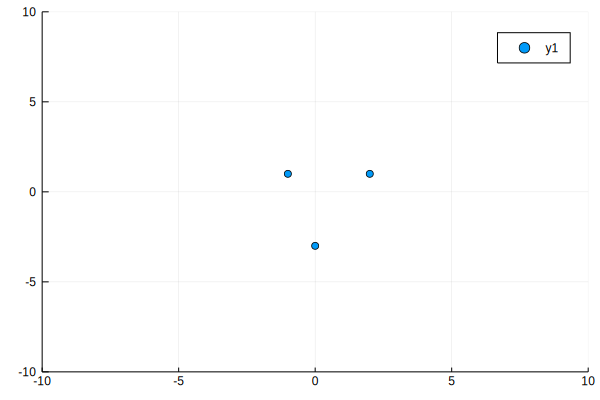

In [6]:
@df org scatter(:x, :y, xlim =(-10,10), ylim = (-10,10))

### Gravitation center

Gravitation center is mean of each (x,y).

In [7]:
gcx = mean(org.x)
gcy = mean(org.y)
[gcx,gcy]

2-element Array{Float64,1}:
  0.3333333333333333
 -0.3333333333333333

Shift so that gravity center equals to origin.

In [8]:
org2 = DataFrame(x = org.x .- gcx, y = org.y .- gcy)

,x,y
,Float64,Float64
1,1.66667,1.33333
2,-1.33333,1.33333
3,-0.333333,-2.66667


In [9]:
combine(org2, :x => mean, :y => mean)

,x_mean,y_mean
,Float64,Float64
1,5.55112e-17,0.0


### Randomized copy

Create randomized copy of original data.

In [10]:
bdat = randn(Float64,size(org2)) .* 0.2 .+ org2

,x,y
,Float64,Float64
1,1.88891,1.34595
2,-1.5606,1.43577
3,-0.20318,-2.74806


In [11]:
function rotdf(A,ang)
    Ax = A[:,1]
    Ay = A[:,2]
    DataFrame(x = Ax .* cosd(ang) .- Ay .* sind(ang), y = Ax .* sind(ang) .+ Ay .* cosd(ang) )
end

rotdf (generic function with 1 method)

In [12]:
bdat2 = rotdf(bdat, 30)

,x,y
,Float64,Float64
1,0.962871,2.11008
2,-2.06941,0.463117
3,1.19807,-2.48148


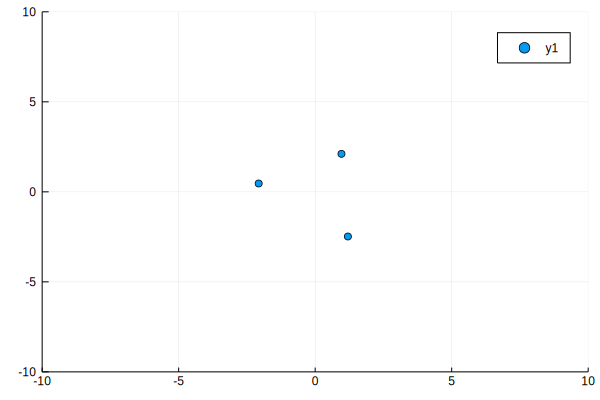

In [13]:
@df bdat2 scatter(:x, :y, xlim =(-10,10), ylim = (-10,10))

### Rotate to fit

Define rotation angle to fit from A,B data. Inputs are (x,y) DataFrame type.

In [14]:
function calcrot(B,A)
    Bx = B[:,1]
    By = B[:,2]
    Ax = A[:,1]
    Ay = A[:,2]
    
    a = sum(Bx .* Ay .- Ax .* By)
    b = sum(Bx .* Ax .+ By .* Ay)
    
    atand(a/b)
end

calcrot (generic function with 1 method)

In [15]:
th = calcrot(bdat2,org)

-31.11420117683816

In [16]:
bdat2_rev = rotdf(bdat2, th)

,x,y
,Float64,Float64
1,1.91473,1.30896
2,-1.53238,1.46585
3,-0.256578,-2.74359


In [91]:
org2

,x,y
,Float64,Float64
1,1.66667,1.33333
2,-1.33333,1.33333
3,-0.333333,-2.66667


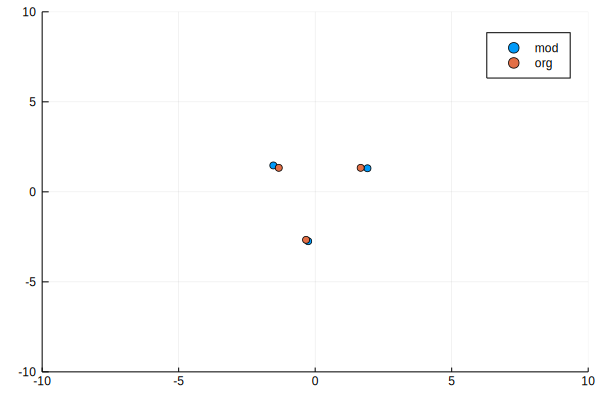

In [17]:
@df bdat2_rev scatter(:x, :y, xlim =(-10,10), ylim = (-10,10), label = "mod")
@df org2 scatter!(:x, :y, label = "org")

## Procedure2 - Number of points differs 

Suppose A has fewer points than B.

### Sample data

Create sample data from bdat

In [18]:
bdat2 = rotdf(bdat,5)

,x,y
,Float64,Float64
1,1.76442,1.50545
2,-1.6798,1.2943
3,0.0371023,-2.75531


In [19]:
cs = DataFrame(x = circshift(bdat2.x,1), y = circshift(bdat2.y,1))

,x,y
,Float64,Float64
1,0.0371023,-2.75531
2,1.76442,1.50545
3,-1.6798,1.2943


Make midpoints of each pair.

In [20]:
m2 = DataFrame( x = (bdat2.x .+ cs.x)/2, y = (bdat2.y .+ cs.y)/2 )

,x,y
,Float64,Float64
1,0.900759,-0.624927
2,0.0423099,1.39987
3,-0.821347,-0.730507


In [21]:
bdat3 = vcat(bdat2,m2)

,x,y
,Float64,Float64
1,1.76442,1.50545
2,-1.6798,1.2943
3,0.0371023,-2.75531
4,0.900759,-0.624927
5,0.0423099,1.39987
6,-0.821347,-0.730507


In [22]:
bdat3 = bdat3[shuffle(1:length(bdat3.x)),:]

,x,y
,Float64,Float64
1,-1.6798,1.2943
2,0.900759,-0.624927
3,0.0423099,1.39987
4,1.76442,1.50545
5,-0.821347,-0.730507
6,0.0371023,-2.75531


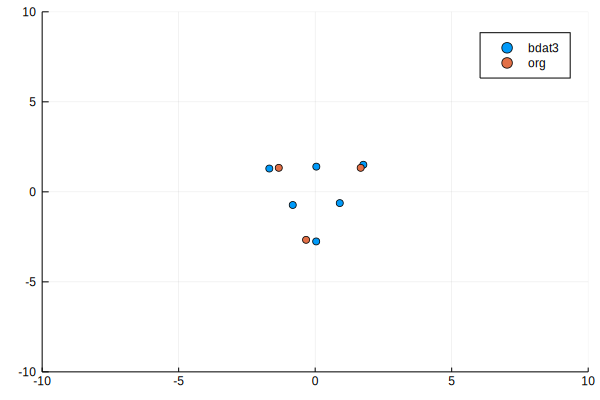

In [23]:
@df bdat3 scatter(:x, :y, xlim =(-10,10), ylim = (-10,10), label = "bdat3")
@df org2 scatter!(:x, :y, label = "org")

### Choosing nearest points

Function to search A's nearest points from B and return it as a DataFrame.

In [24]:
function nearestpoints(B,A)
    if nrow(A) <= nrow(B)
        C = similar(A)
        for i in 1:nrow(A)
            dd = Inf
            ind = 0
            Ax = A[i,1]
            Ay = A[i,2]
            for j in 1:nrow(B)
                Bx = B[j,1]
                By = B[j,2]
                d1 = (Bx - Ax)^2 + (By - Ay)^2
                if d1 < dd
                    ind = j
                    dd = d1
                end
            end
            C[i,1] = B[ind,1]
            C[i,2] = B[ind,2]
        end
        return(C)
    else
        println("rows of $A must be smaller than rows of $B")
        return(missing)
    end
end

nearestpoints (generic function with 1 method)

In [25]:
bdat3b = nearestpoints(bdat3,org2)

,x,y
,Float64,Float64
1,1.76442,1.50545
2,-1.6798,1.2943
3,0.0371023,-2.75531


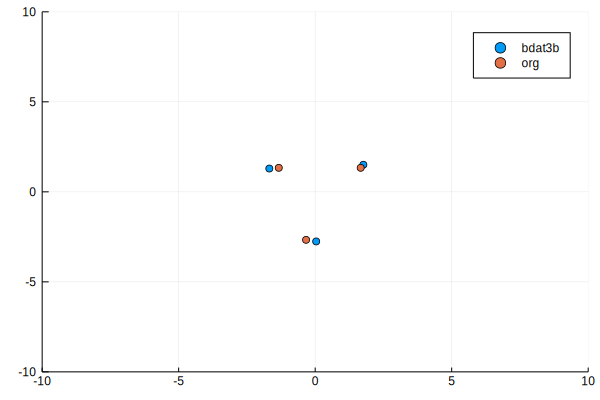

In [26]:
@df bdat3b scatter(:x, :y, xlim =(-10,10), ylim = (-10,10), label = "bdat3b")
@df org2 scatter!(:x, :y, label = "org")

### Rotate to fit

Now we can calc rotation angle to fit bdat3

In [27]:
th = calcrot(bdat3b, org2)

-5.9306658020703305

In [28]:
bdat3_rev = rotdf(bdat3, th)

,x,y
,Float64,Float64
1,-1.53707,1.46093
2,0.831368,-0.714653
3,0.186725,1.38801
4,1.91052,1.31509
5,-0.89243,-0.641731
6,-0.247788,-2.74439


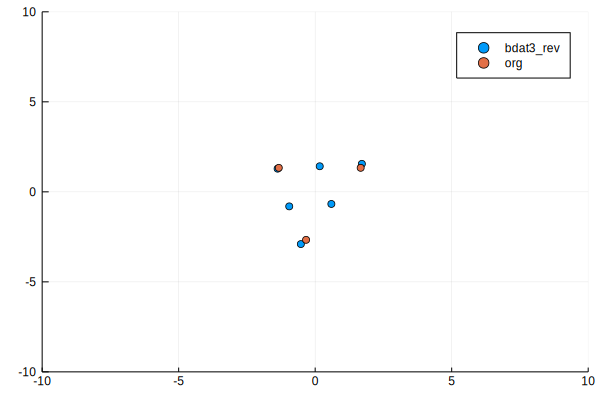

In [135]:
@df bdat3_rev scatter(:x, :y, xlim =(-10,10), ylim = (-10,10), label = "bdat3_rev")
@df org2 scatter!(:x, :y, label = "org")